# RL - Personnal assignment - Hugo THEVENET

## Recquirements

In [ ]:
#%pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [48]:
import os, sys
import gymnasium as gym
import time
from agent import MCQAgent, NStepTreeBackupAgent
import text_flappy_bird_gym
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import random

## Implementing the agents

In [70]:
class MCQ_agent:
    def __init__(self, env, decaying, eps):
        self.env = env
        self.decaying = decaying

        self.eps = eps
        self.eps_decay = 0.99999
        self.eps_min = 0.0001

        self.action_space = env.action_space.n
        self.q_table = {}
        self.state_action_count = {}

        self.episode_states_actions_rewards = []

    def policy(self, state):
        # epsilon-greedy policy
        if np.random.random() < self.eps:
            return self.env.action_space.sample()
        else:
            if state not in self.q_table.keys():
                self.init_state(state)

            return np.argmax(self.q_table[state])
        

    def init_state(self, state):
        self.q_table[state] = np.random.rand(self.env.action_space.n)
        self.state_action_count[state] = np.zeros(self.env.action_space.n)

    def start_episode(self):
        self.episode_states_actions_rewards = []
        if self.decaying:
            self.eps = max(self.eps_decay*self.eps, self.eps_min)

    def update(self, state, action, reward, next_state, done):
        self.episode_states_actions_rewards.append((state, action, reward))

        if done: # AT THE END OF THE EPISODE
            G = 0
            for past_state, past_action, past_reward in self.episode_states_actions_rewards[::-1]:
                if past_state not in self.q_table.keys():
                    self.init_state(past_state)

                G = past_reward + G
                self.state_action_count[past_state][past_action] += 1
                self.q_table[past_state][past_action] += 1 / self.state_action_count[past_state][past_action] * (G - self.q_table[past_state][past_action])


In [50]:
class SARSALambdaAgent:
    def __init__(self, env, decaying, lambda_value=0.9, alpha=0.1, gamma=0.99, eps=0.1):
        self.decaying = decaying
        self.env = env
        self.lambda_value = lambda_value
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = eps

        self.action_space = env.action_space.n
        
        self.q_table = {}
        self.z_table = {}
        #z = z_table
        #w = q_table

        self.eps_decay = 0.99999
        self.eps_min = 0.0001
    def policy(self, state):
        # epsilon-greedy policy
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            self.check_init_qtable(state)

            return np.argmax(self.q_table[state])


    def check_init_qtable(self, state):
        if self.q_table.get(state) is None:
            self.q_table[state] = np.random.rand(self.env.action_space.n)

    def check_init_ztable(self, state):
        if self.z_table.get(state) is None:
            self.z_table[state] = np.zeros(self.env.action_space.n)
        
    def start_episode(self):
        if self.decaying:
            self.epsilon = max(self.eps_decay*self.epsilon, self.eps_min)
        for state in self.z_table:
            self.z_table[state] = np.zeros(self.action_space)

    def update(self, state, action, reward, next_state, done):
        next_action = self.policy(next_state)

        #Init if not seen :
        self.check_init_qtable(state)
        self.check_init_qtable(next_state)
        self.check_init_ztable(state)
        self.check_init_ztable(next_state)
        
        delta = reward - self.q_table[state][action] + self.gamma * self.q_table[next_state][next_action]
        self.z_table[state][action] += 1

        for s in self.q_table.keys():
            self.q_table[s] += self.alpha * delta * self.z_table[s]
            self.z_table[s] *= self.gamma * self.lambda_value
                
        
            

## Comparision and analysis : reward, score, state-value...

## Utils functions

Function for training an agent, given a environment (suitable for screen environment)

In [72]:
def train_FB(agent, env, env_name, num_episodes):
    scores = []
    rewards = []
    for episode in trange(num_episodes):

        state = env.reset()
        state = state[0]
        if env_name == 'TextFlappyBird-screen-v0':
            state = tuple(state.flatten())
            
        done = False
        episode_score = 0
        total_reward = 0

        agent.start_episode()

        while not done:
            action = agent.policy(state)
            
            next_state, reward, done, _, info = env.step(action)
            if env_name == 'TextFlappyBird-screen-v0':
                next_state = tuple(next_state.flatten())
            
            agent.update(state, action, reward, next_state, done)

            state = next_state

            episode_score = info['score']
            total_reward += reward
        
        rewards.append(total_reward)
        scores.append(episode_score)

    env.close()
    return scores, rewards, agent

Moving average scores function for better render

In [73]:
#plot evolution scores
def moving_average(data, window_size=100):
    """Calculate the moving average of a list."""
    moving_avg = []
    for i in range(len(data)):
        window = data[max(0, i - window_size + 1): i + 1]
        avg = sum(window) / len(window) if window else 0
        moving_avg.append(avg)
    return moving_avg

Train and plot function

In [62]:
def train_and_plot(plot, decaying, env, env_name, agents, params, num_episodes):
    Q_tables = []
    for agent_name, agent_class in agents.items():
        for param_name, param_value in params[agent_name].items():
            if 'scores' == plot:
                plt.title(f"Scores for {agent_name} with {param_name} in {param_value}")
            if 'rewards' == plot:
                plt.title(f"Rewards for {agent_name} with {param_name} in {param_value}")

            for param in param_value:
                print(f"\nTraining {agent_name} with {param_name} = {param} on {num_episodes} episodes.")
                agent = agent_class(env, decaying, **{param_name: param})
                scores, rewards, agent = train_FB(agent, env, env_name, num_episodes)
                if agent_name in ['MCQ_agent', 'SARSALambdaAgent']:
                    Q_tables.append({'agent_name': agent_name, 'agent params':f"{param_name} : {param_value}", 'q_table':agent.q_table})
                if 'scores' == plot:
                    plt.plot(moving_average(scores), label=f"{agent_name}, {param_name}={param}")
                    plt.ylabel("Score")
                    plt.xlabel("Episode")

                if 'rewards' == plot:
                    plt.plot(moving_average(rewards), label=f"{agent_name}, {param_name}={param}")
                    plt.ylabel("Reward")
                    plt.xlabel("Episode")

            if 'scores' == plot or 'rewards' == plot:
                plt.legend()
                plt.show()
    #Then print Q_tables if environement is text
    if 'state_value' == plot and env_name == 'TextFlappyBird-v0':        
        for table in Q_tables:
            grid = np.zeros((22,14))
            for state, q_values in table['q_table'].items():
                x, y = state
                grid[y,(x+4)%14] = q_values[1]
            #show grid as a heatmap
            plt.imshow(grid)
            plt.colorbar()
            plt.title(f"Q-values (action 1) for {table['agent_name']} with {table['agent params']}")
            plt.show()
            


## Score comparision

Comparing Agents and look for the best parameters


Training MCQ_agent with eps = 0.001 on 3000 episodes.


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:03<00:00, 806.94it/s] 



Training MCQ_agent with eps = 0.01 on 3000 episodes.


100%|██████████| 3000/3000 [00:06<00:00, 456.14it/s]



Training MCQ_agent with eps = 0.1 on 3000 episodes.


100%|██████████| 3000/3000 [00:07<00:00, 401.27it/s]



Training MCQ_agent with eps = 0.3 on 3000 episodes.


100%|██████████| 3000/3000 [00:03<00:00, 760.47it/s]



Training MCQ_agent with eps = 0.5 on 3000 episodes.


100%|██████████| 3000/3000 [00:02<00:00, 1015.90it/s]


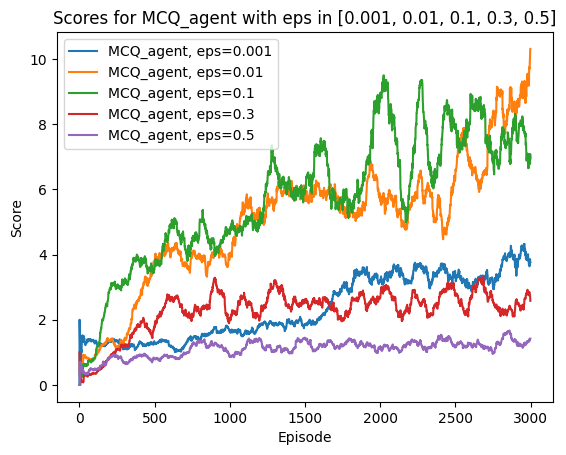


Training SARSALambdaAgent with lambda_value = 0.8 on 3000 episodes.


100%|██████████| 3000/3000 [02:59<00:00, 16.74it/s]



Training SARSALambdaAgent with lambda_value = 0.9 on 3000 episodes.


100%|██████████| 3000/3000 [04:24<00:00, 11.33it/s]



Training SARSALambdaAgent with lambda_value = 0.95 on 3000 episodes.


100%|██████████| 3000/3000 [03:43<00:00, 13.40it/s]


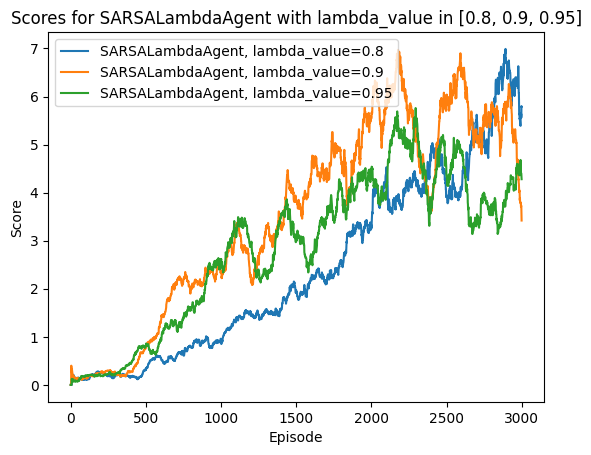

In [74]:
# initiate environment
env_name = 'TextFlappyBird-v0'
env = gym.make(env_name, height=15, width=20, pipe_gap=4)

# define agents and parameters to vary
agents = {
    "MCQ_agent": MCQ_agent,
    "SARSALambdaAgent": SARSALambdaAgent,
}
params = {
    "MCQ_agent": {"eps": [0.001,0.01,0.1, 0.3, 0.5]},
    "SARSALambdaAgent": {"lambda_value": [0.8,0.9,0.95]},
}

# Learning phase
num_episodes = 3000
train_and_plot(plot = 'scores', 
               decaying = True, 
               env = env, 
               env_name = env_name, 
               agents = agents, 
               params = params, 
               num_episodes = num_episodes)

## Reward comparision

Comparing agents in terms of rewards.


Training MCQ_agent with eps = 0.001 on 10000 episodes.


100%|██████████| 10000/10000 [00:11<00:00, 834.80it/s]



Training MCQ_agent with eps = 0.01 on 10000 episodes.


100%|██████████| 10000/10000 [01:19<00:00, 125.14it/s]



Training MCQ_agent with eps = 0.1 on 10000 episodes.


100%|██████████| 10000/10000 [00:35<00:00, 284.65it/s]



Training MCQ_agent with eps = 0.3 on 10000 episodes.


100%|██████████| 10000/10000 [00:17<00:00, 574.40it/s]



Training MCQ_agent with eps = 0.5 on 10000 episodes.


100%|██████████| 10000/10000 [00:11<00:00, 893.14it/s]


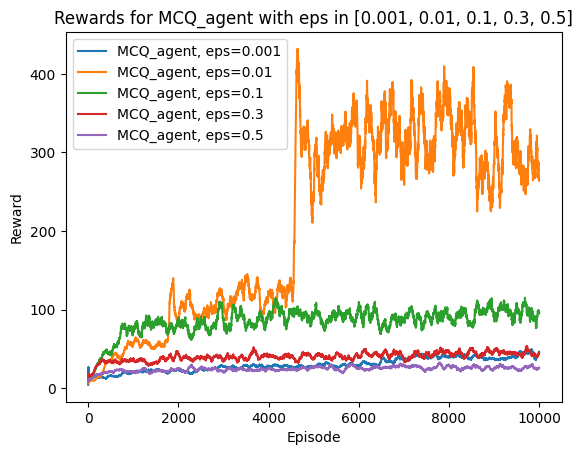


Training SARSALambdaAgent with lambda_value = 0.8 on 10000 episodes.


100%|██████████| 10000/10000 [20:28<00:00,  8.14it/s]



Training SARSALambdaAgent with lambda_value = 0.9 on 10000 episodes.


100%|██████████| 10000/10000 [15:36<00:00, 10.68it/s]



Training SARSALambdaAgent with lambda_value = 0.95 on 10000 episodes.


100%|██████████| 10000/10000 [13:02<00:00, 12.78it/s]


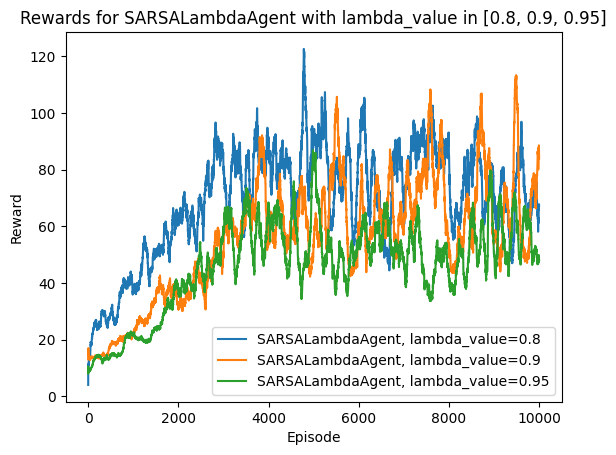

In [75]:
# initiate environment
env_name = 'TextFlappyBird-v0'
env = gym.make(env_name, height=15, width=20, pipe_gap=4)

# define agents and parameters to vary
agents = {
    "MCQ_agent": MCQ_agent,
    "SARSALambdaAgent": SARSALambdaAgent,
}
params = {
    "MCQ_agent": {"eps": [0.001,0.01,0.1, 0.3, 0.5]},
    "SARSALambdaAgent": {"lambda_value": [0.8,0.9,0.95]},
}

# Learning phase
num_episodes = 10000
train_and_plot(plot = 'rewards', 
               decaying = True, 
               env = env, 
               env_name = env_name, 
               agents = agents, 
               params = params, 
               num_episodes = num_episodes)


## State value comparision 

Comparing agents in terms of state_value function :


Training MCQ_agent with eps = 0.001 on 10000 episodes.


100%|██████████| 10000/10000 [00:12<00:00, 803.82it/s]



Training MCQ_agent with eps = 0.01 on 10000 episodes.


100%|██████████| 10000/10000 [00:51<00:00, 195.19it/s]



Training MCQ_agent with eps = 0.1 on 10000 episodes.


100%|██████████| 10000/10000 [00:32<00:00, 307.45it/s]



Training MCQ_agent with eps = 0.3 on 10000 episodes.


100%|██████████| 10000/10000 [00:13<00:00, 733.93it/s]



Training MCQ_agent with eps = 0.5 on 10000 episodes.


100%|██████████| 10000/10000 [00:09<00:00, 1105.00it/s]



Training SARSALambdaAgent with lambda_value = 0.8 on 10000 episodes.


100%|██████████| 10000/10000 [18:51<00:00,  8.84it/s]



Training SARSALambdaAgent with lambda_value = 0.9 on 10000 episodes.


100%|██████████| 10000/10000 [24:07<00:00,  6.91it/s]



Training SARSALambdaAgent with lambda_value = 0.95 on 10000 episodes.


100%|██████████| 10000/10000 [15:43<00:00, 10.59it/s]


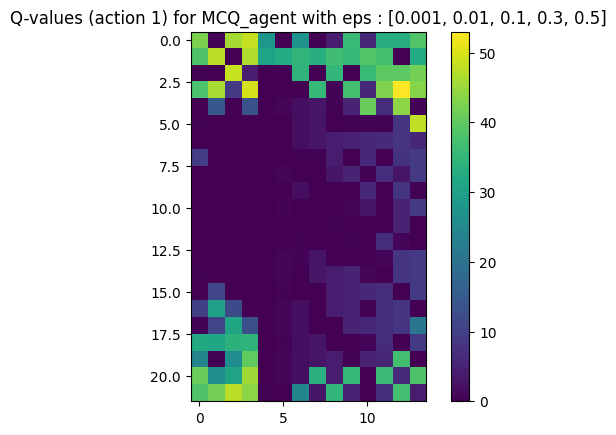

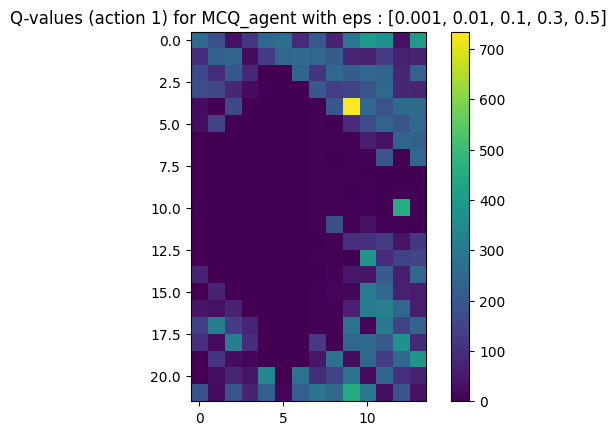

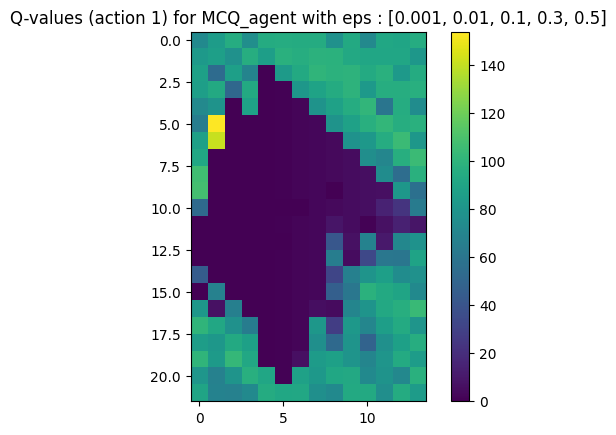

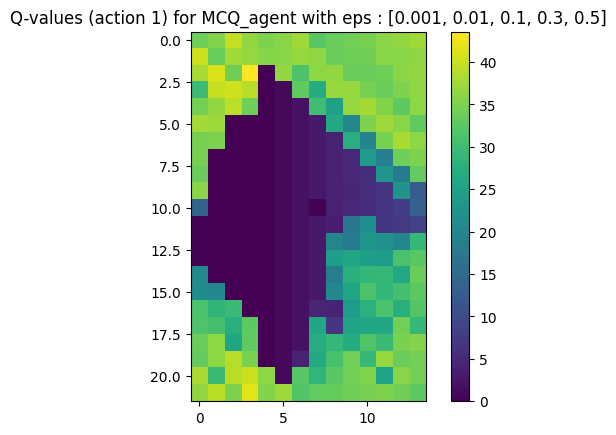

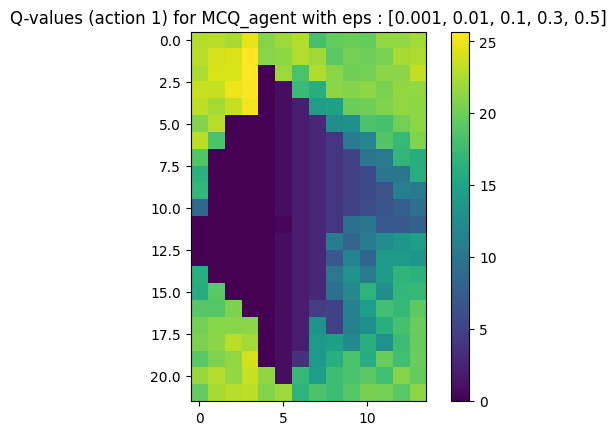

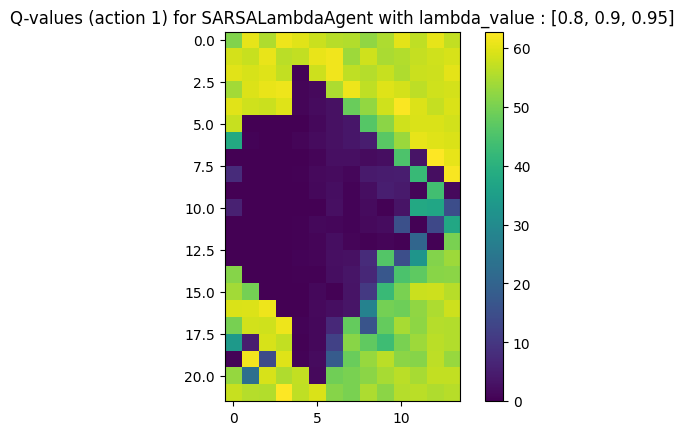

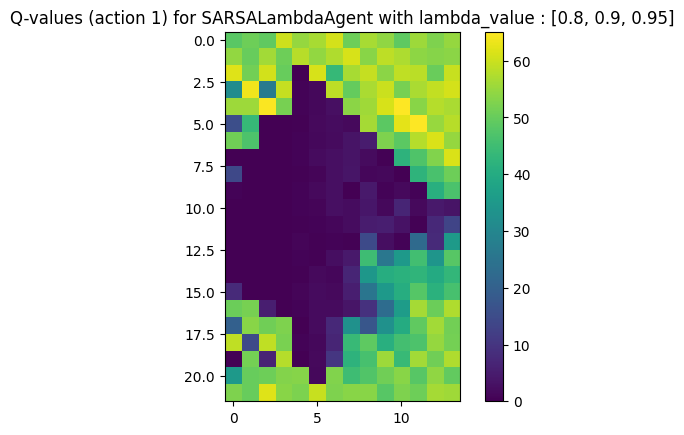

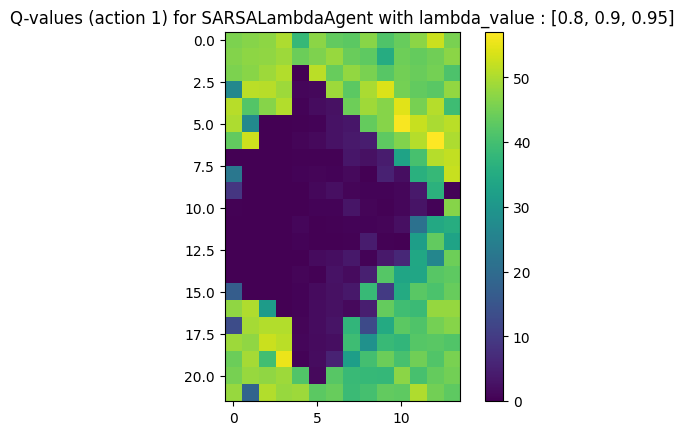

In [76]:

# initiate environment
env_name = 'TextFlappyBird-v0'
env = gym.make(env_name, height=15, width=20, pipe_gap=4)

# define agents and parameters to vary
agents = {
    "MCQ_agent": MCQ_agent,
    "SARSALambdaAgent": SARSALambdaAgent,
}
params = {
    "MCQ_agent": {"eps": [0.001,0.01,0.1, 0.3, 0.5]},
    "SARSALambdaAgent": {"lambda_value": [0.8,0.9,0.95]},
}

# Learning phase
num_episodes = 10000
train_and_plot(plot = 'state_value', 
               decaying = False, 
               env = env, 
               env_name = env_name, 
               agents = agents, 
               params = params, 
               num_episodes = num_episodes)

## Score comparision with best parameters

Comparing the two agents after having optimized the parameters

In [81]:
def comparing_agents(env,decaying, env_name, agents, params, num_episodes):
    
    for agent_name, agent_class in agents.items():
        agent = agent_class(env, decaying, **params[agent_name])
        scores, rewards, agent = train_FB(agent, env, env_name, num_episodes)
        plt.plot(moving_average(scores), label=f"{agent_name}")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

100%|██████████| 10000/10000 [28:59<00:00,  5.75it/s] 


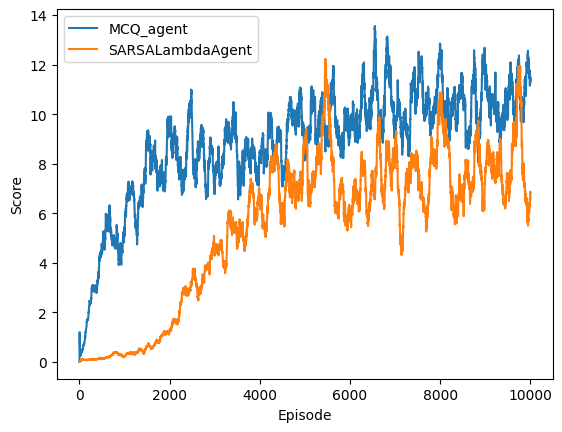

In [82]:
# initiate environment
env_name = 'TextFlappyBird-v0'
env = gym.make(env_name, height=15, width=20, pipe_gap=4)

# define agents and parameters to vary
agents = {
    "MCQ_agent": MCQ_agent,
    "SARSALambdaAgent": SARSALambdaAgent,
}
params = {
    "MCQ_agent": {"eps": 0.1}, #{"eps": [0.001,0.01,0.1, 0.3, 0.5]},
    "SARSALambdaAgent": {"lambda_value": 0.85},
}

# Learning phase
num_episodes = 10000

comparing_agents(env,decaying = True, env_name = env_name, agents = agents, params= params, num_episodes = num_episodes)


# Testing on screen environement

Using TextFlappyBird-screen-v0

Training best agent


Training MCQ_agent with eps = 0.01 on 10000 episodes.


100%|██████████| 10000/10000 [02:57<00:00, 56.29it/s]


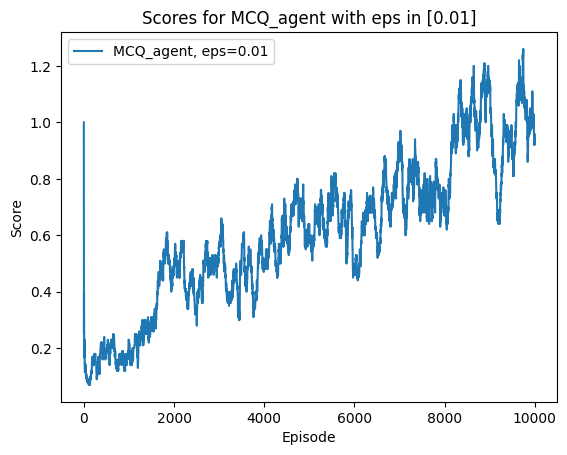

In [ ]:
def test_screen_env():
    # initiate environment
    env_name = 'TextFlappyBird-screen-v0'
    env = gym.make(env_name, height=15, width=20, pipe_gap=4)
    
    # define agents and parameters to vary
    agents = {
        "MCQ_agent": MCQ_agent,
        #"SARSALambdaAgent": SARSALambdaAgent,
    }
    params = {
        "MCQ_agent": {"eps": [0.01]},
        #"SARSALambdaAgent": {"lambda_value": [0.01, 0.1, 0.5, 0.7, 0.9]},
    }

    # Learning phase
    num_episodes = 10000
    train_and_plot(plot = 'scores', 
               decaying = True, 
               env = env, 
               env_name = env_name, 
               agents = agents, 
               params = params, 
               num_episodes = num_episodes)

test_screen_env()